In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys; sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchdiffeq as tde
from functools import singledispatch
from tqdm import tqdm
from terrarium.utils.nets import MLP, OPTIMS
from terrarium.utils.plots import grab_plot, VideoWriter
from terrarium.utils.sugar import attrmethod, buildmethod

100%|██████████| 299/299 [00:00<00:00, 26244.02it/s]


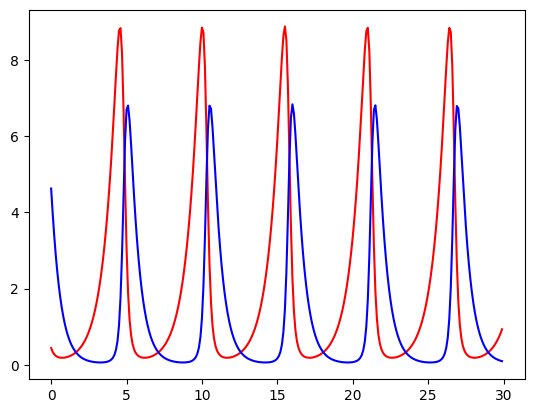

In [2]:
def glv(x, growth_rates, interactions):
    dx = x*(growth_rates + (interactions@x))

    return dx

def k(x, model=glv, dt=.1, *args, **kwargs):
    k1 = model(x, *args, **kwargs)
    k2 = model(x + k1*dt/2, *args, **kwargs)
    k3 = model(x + k2*dt/2, *args, **kwargs)
    k4 = model(x + k3*dt, *args, **kwargs)

    return k1, k2, k3, k4

@singledispatch
def rk_int(x0, model=glv, dt=.1, n_steps=300, *args, **kwargs):
    (X := np.zeros((n_steps, len(x))))[0] = x0

    for i in tqdm(range(1, n_steps)):
        k1, k2, k3, k4 = k(x := X[i - 1], model, dt, *args, **kwargs)
        X[i] = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6

    return X

@rk_int.register(torch.Tensor)
def _(x0, model=glv, dt=.1, n_steps=300, *args, **kwargs):
    (X := torch.zeros(n_steps, len(x0)))[0] = x0

    for i in tqdm(range(1, n_steps)):
        k1, k2, k3, k4 = k(x := X[i - 1], model, dt, *args, **kwargs)
        X[i] = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6

    return X

dt, n_steps = .1, 300
x0 = torch.tensor((.44249296, 4.6280594))
growth_rates = torch.tensor((1.3, -1.8))
interactions = torch.tensor(((0., -.9), (.8, 0.)))
steps = torch.arange(n_steps)

X = rk_int(x0, glv, dt, n_steps, growth_rates, interactions)
plt.plot(steps*dt, X[:, 0], c='red')
plt.plot(steps*dt, X[:, 1], c='blue')
plt.show()

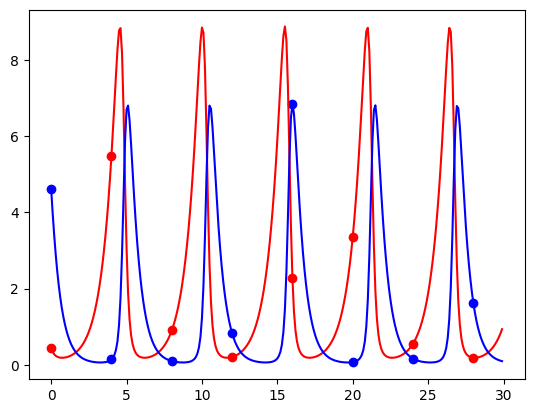

In [3]:
data = X[idx := torch.arange(0, len(X), 40)]
plt.plot(steps*dt, X[:, 0], c='red')
plt.plot(steps*dt, X[:, 1], c='blue')
plt.scatter(idx*dt, data[:, 0], c='red')
plt.scatter(idx*dt, data[:, 1], c='blue')
plt.show()

In [4]:
class GLV(nn.Module):
    @attrmethod
    def __init__(self, optim='adam', *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.log_ = []
        self.g_log_ = []
        self.i_log_ = []

    def _build(self, x0, learning_rate=1e-3):
        # self.growth_rates_ = nn.Parameter(.02*torch.rand(c := len(x0), requires_grad=True) - .01)
        self.growth_rates_ = nn.Parameter(torch.zeros(c := len(x0), requires_grad=True))
        # self.growth_rates_ = torch.tensor((1.3, -1.8))
        # self.interactions_ = nn.Parameter(.02*torch.rand(c := len(x0), c, requires_grad=True) - .01)
        self.interactions_ = nn.Parameter(torch.zeros(c, c, requires_grad=True))
        # self.interactions_ = torch.tensor(((0., -.9), (.8, 0.)))
        # self.m = MLP(c := len(x0), 2*c, 4*c, 2*c, c, act_layer='relu')
        self._optim = OPTIMS[self.optim](self.parameters(), learning_rate)

        return self

    def step(self, loss):
        loss.backward()
        self._optim.step()
        self._optim.zero_grad()

        self.g_log_.append(self.growth_rates_.clone().detach())
        self.i_log_.append(self.interactions_.clone().detach())

        return self

    def model(self, x, growth_rates=None, interactions=None):
        if growth_rates is None:
            growth_rates = self.growth_rates_

        if interactions is None:
            interactions = self.interactions_

        dx = x*(growth_rates + interactions@x)
        # dx = self.m(x)

        return dx

    def forward(self, x, y=None, dt=.1, *args, **kwargs):
        k1 = self.model(x, *args, **kwargs)
        k2 = self.model(x + k1*dt/2, *args, **kwargs)
        k3 = self.model(x + k2*dt/2, *args, **kwargs)
        k4 = self.model(x + k3*dt, *args, **kwargs)
        x_ = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6
        # x_ = x + self.model(x)*dt

        if y is not None:
            loss = (x_ - y).square().sum()
            
            return x_, loss
        return x_

    @buildmethod
    def fit(self, Y, x0, dt=.1, n_epochs=1000, n_steps=300, learning_rate=1e-3, verbosity=1):
        for _ in tqdm(range(n_epochs)) if verbosity > 0 else range(n_epochs):
            x, idx, loss = x0.clone(), -1, 0

            for i in range(n_steps):
                if i in Y[1:, 0]:
                    x, l = self(x, Y[idx := idx + 1, 1:])
                    loss += l
                else:
                    x = self(x)

            self.step(loss)
            self.log_.append(loss.item())

        return self

100%|██████████| 500/500 [00:12<00:00, 39.09it/s]


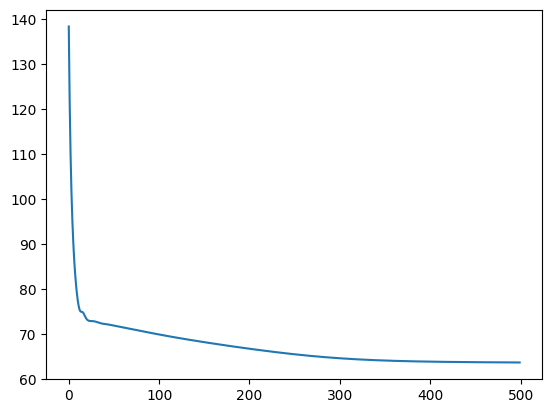

In [29]:
Y = torch.cat((idx[:, None], data), -1)
model = GLV()
model.fit(Y, x0, n_epochs=500)
plt.plot(range(len(model.log_)), model.log_)
plt.show()

In [32]:
with VideoWriter(frame_rate=30., path='output/_autoplay.mp4') as vid:
    for i in tqdm(range(len(model.log_))):
        (Y := torch.zeros((300, 2)))[0] = x0
        steps = torch.arange(len(X_))

        for j in range(1, 300):
            Y[j] = model(Y[j - 1], growth_rates=model.g_log_[i], interactions=model.i_log_[i])

        plt.plot(steps*dt, X[:, 0], c='red', alpha=.1)
        plt.plot(steps*dt, X[:, 1], c='blue', alpha=.1)
        plt.scatter(idx*dt, data[:, 0], c='red', alpha=.5)
        plt.scatter(idx*dt, data[:, 1], c='blue', alpha=.5)
        plt.plot(steps*dt, Y[:, 0].detach(), c='red')
        plt.plot(steps*dt, Y[:, 1].detach(), c='blue')
        vid.write(grab_plot())

100%|██████████| 500/500 [00:11<00:00, 44.28it/s]


100%|██████████| 299/299 [00:00<00:00, 14616.68it/s]


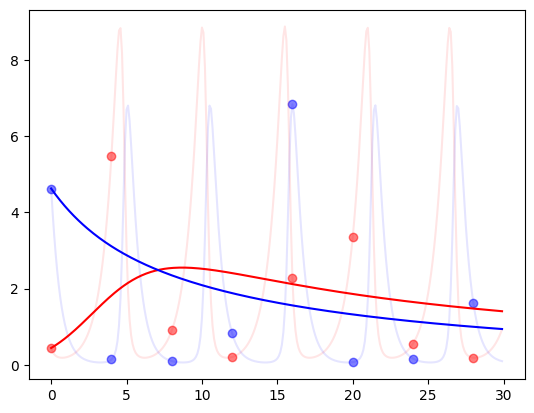

In [31]:
(X_ := torch.zeros((300, 2)))[0] = x0

for i in tqdm(range(1, 300)):
    X_[i] = model(X_[i - 1])

plt.plot(steps*dt, X[:, 0], c='red', alpha=.1)
plt.plot(steps*dt, X[:, 1], c='blue', alpha=.1)
plt.scatter(idx*dt, data[:, 0], c='red', alpha=.5)
plt.scatter(idx*dt, data[:, 1], c='blue', alpha=.5)
plt.plot(steps*dt, X_[:, 0].detach(), c='red')
plt.plot(steps*dt, X_[:, 1].detach(), c='blue')
plt.show()

In [ ]:
class UDE(nn.Module):
    @attrmethod
    def __init__(self, bias=True, norm_layer='batch', act_layer='relu', optim='adam', *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _build(self, x0, learning_rate=1e-1):
        channels = (in_channels := len(x0), 2*in_channels, in_channels)
        self.model_ = MLP(*channels, bias=self.bias, norm_layer=self.norm_layer, act_layer=self.act_layer)
        self._optim = OPTIMS[self.optim](self.parameters(), learning_rate)

        return self

    @buildmethod
    def fit(self, x0, n_steps=300, n_epochs=1000, learning_rate=1e-1, verbosity=1):
        for i in tqdm(range(n_epochs)) if verbosity > 0 else range(n_epochs):
            pass

In [23]:
data

tensor([[0.4425, 4.6281],
        [3.0801, 6.6994],
        [8.8519, 1.2231],
        [5.9141, 0.1691],
        [3.3643, 0.0719],
        [1.8821, 0.0642]])